In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne

## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [67]:
def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [68]:
targets = 40

def print_graphs(data):
    for i in range(0, targets, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, targets, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, targets, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [69]:
data = np.load("../../datasets/beta/data.npy")

print(data.shape)
data = data[0]
print(data.shape)



(4, 40, 64, 750)
(40, 64, 750)


Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

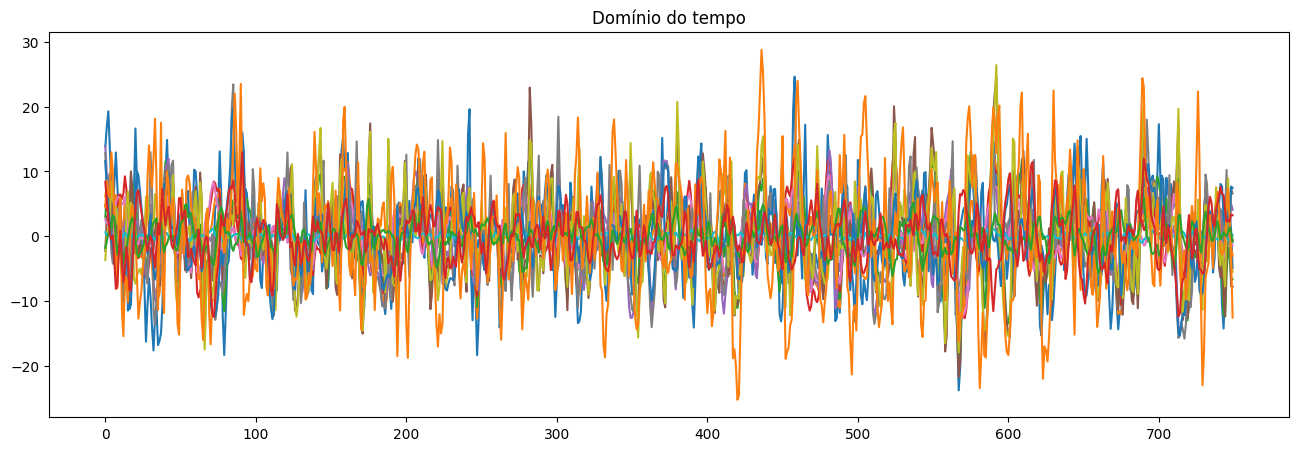

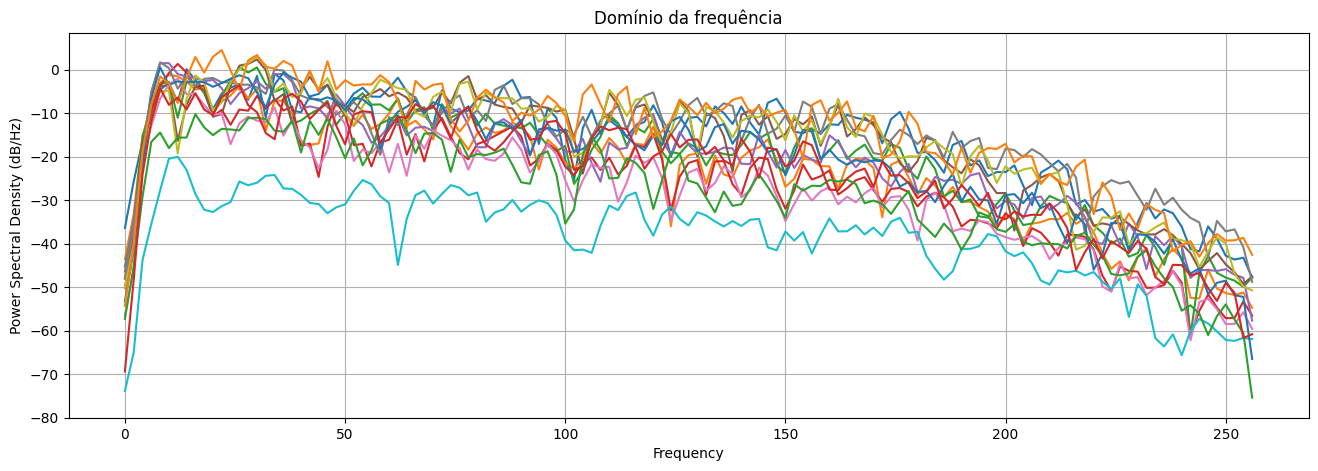

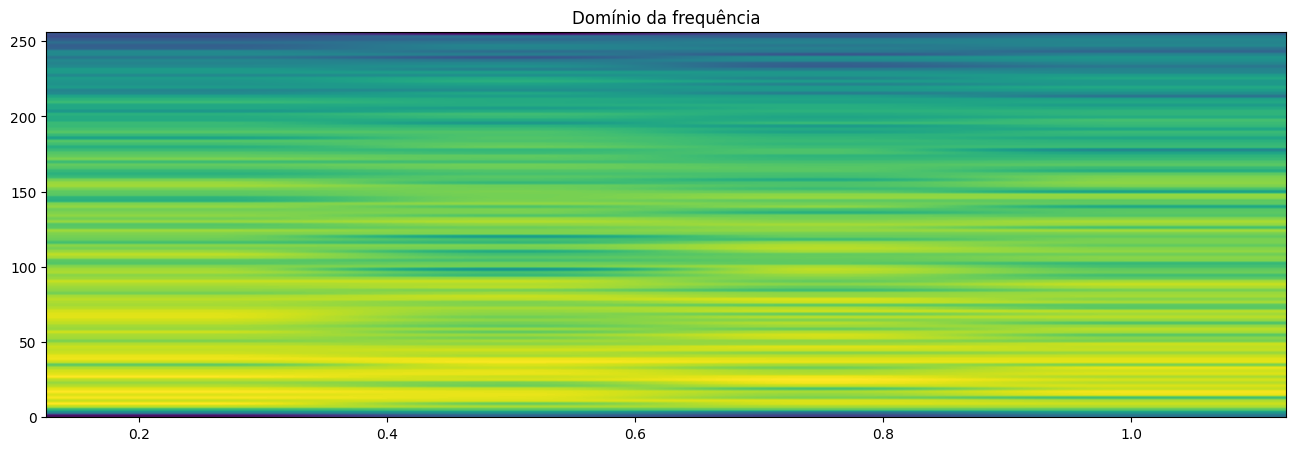

In [70]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data[0])

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [71]:
# criação de um objeto "info"
n_channels = 64
sfreq = 512
ch_names = ['Oz'] * n_channels# colocar todos os eletrodos nesta merda
ch_types = ['eeg'] * n_channels
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)

In [72]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../../datasets/beta/labels.npy")
unique_labels = sorted(set(labels))
event_dict = {str(value): index  for index, value in enumerate(unique_labels)}


In [75]:
# data : array, shape (n_epochs, n_channels, n_times)
# data_correct = data.reshape(40, n_channels, data.shape[2])
data_correct = data

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(40, dtype=int),
    le.fit_transform(labels))
)


mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated


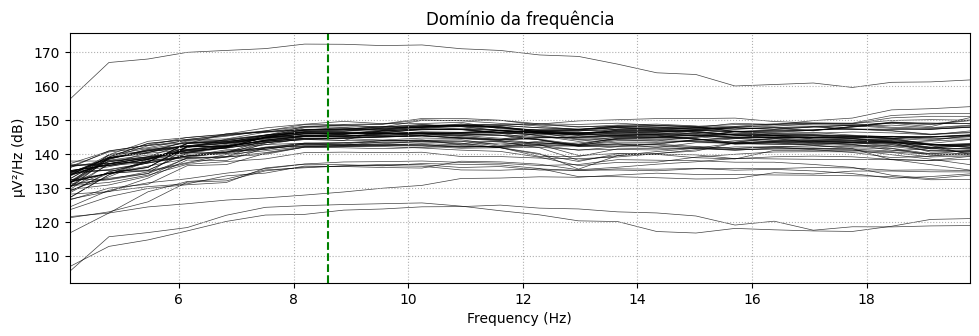

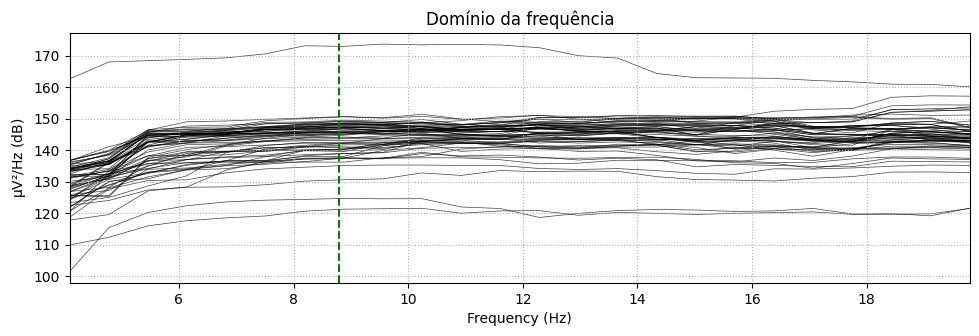

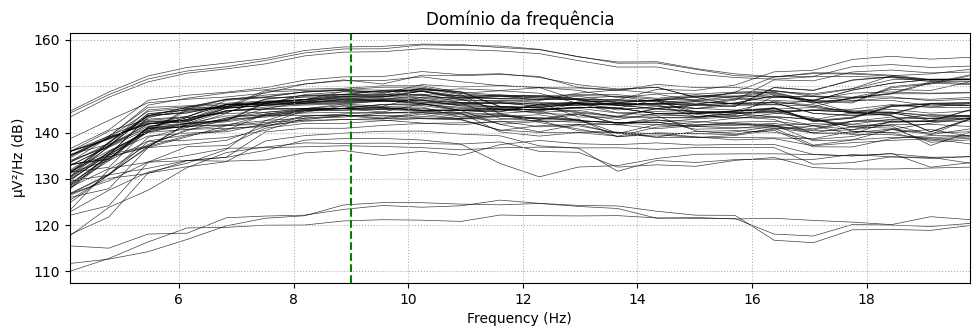

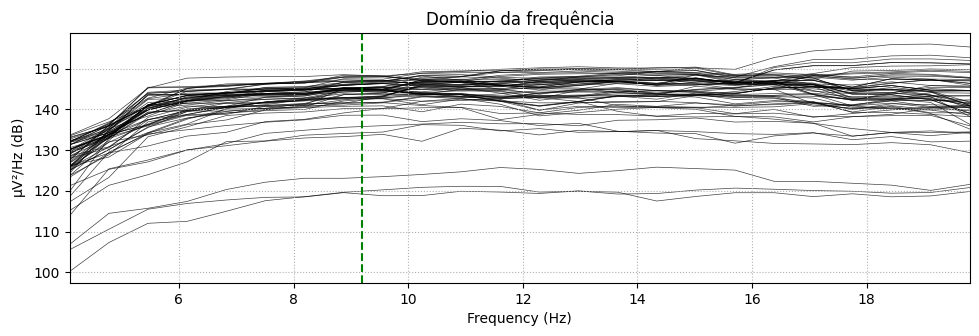

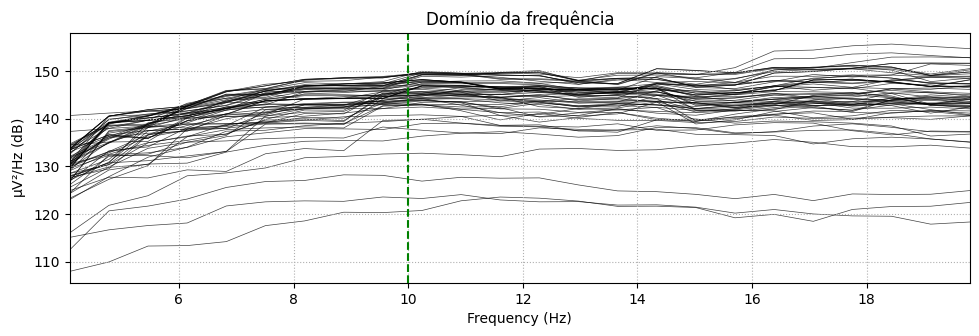

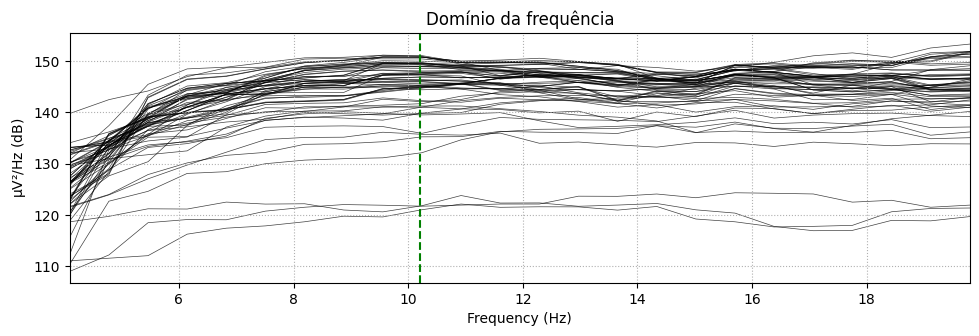

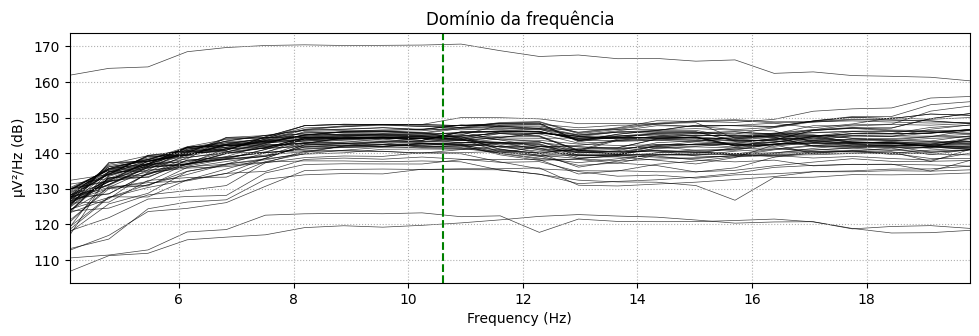

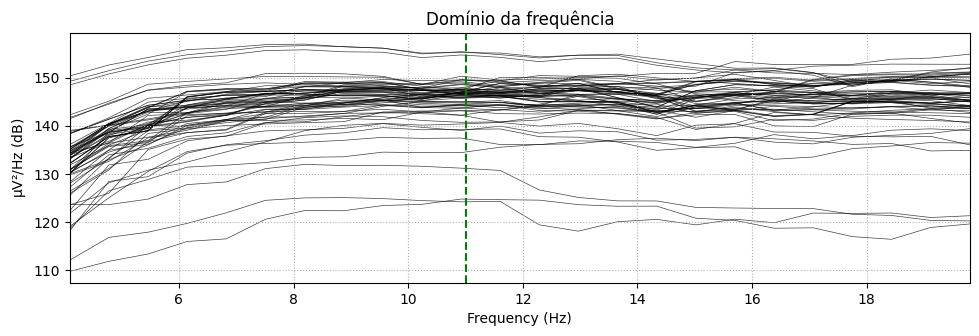

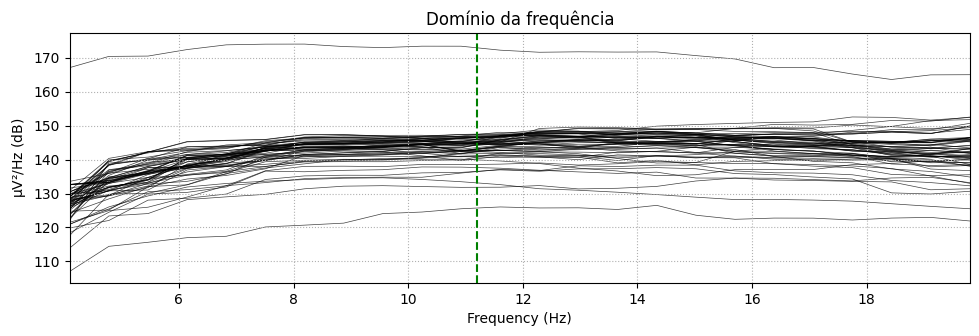

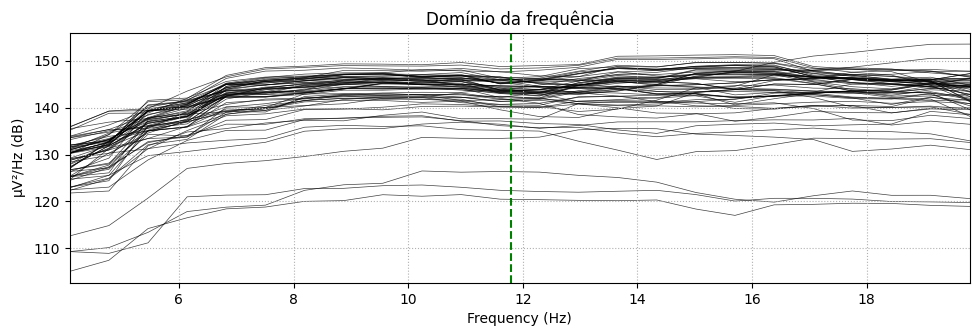

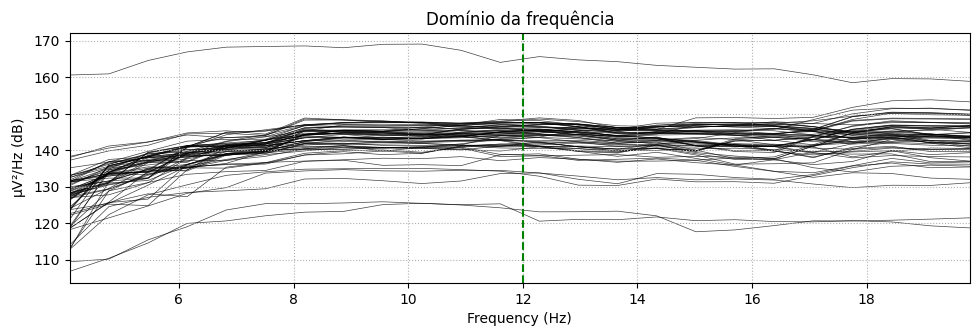

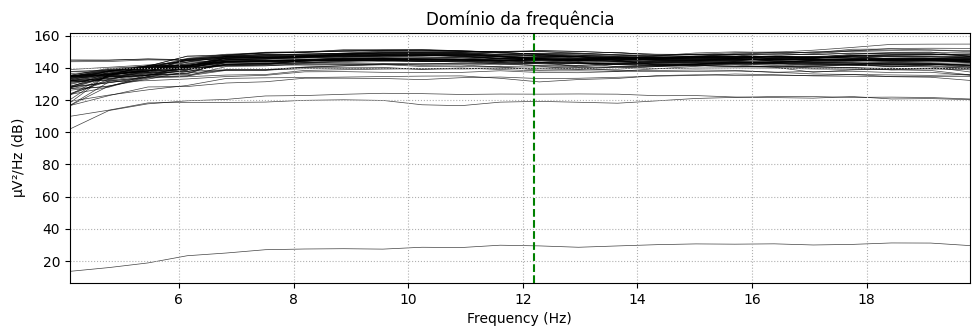

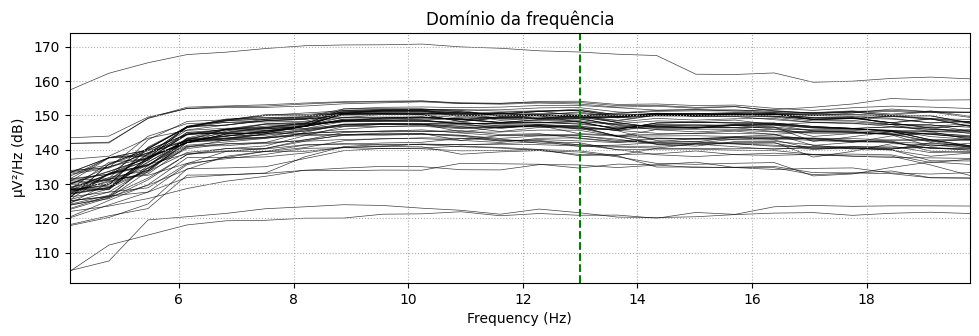

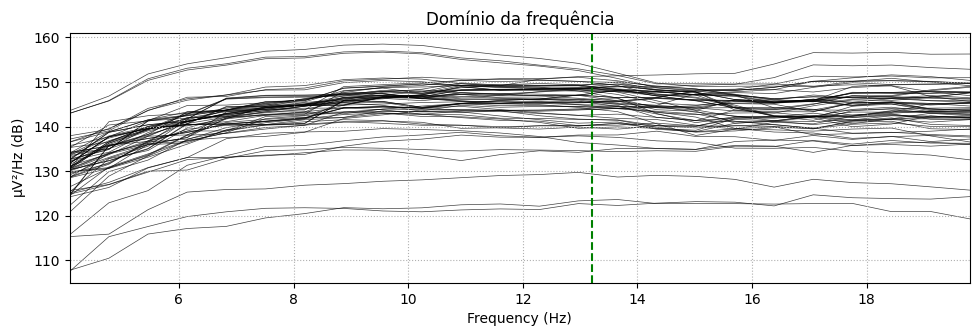

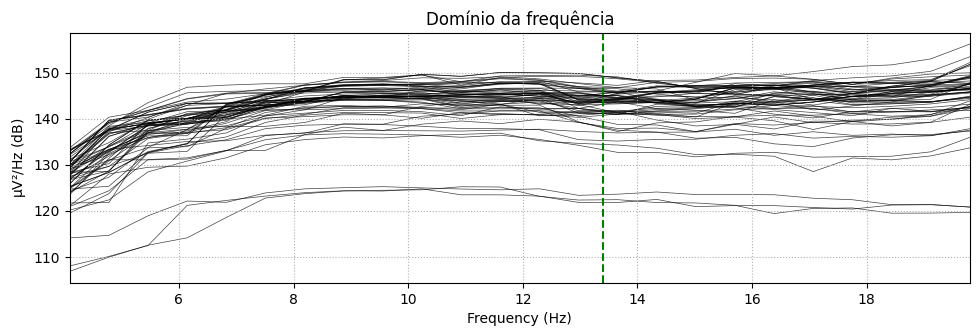

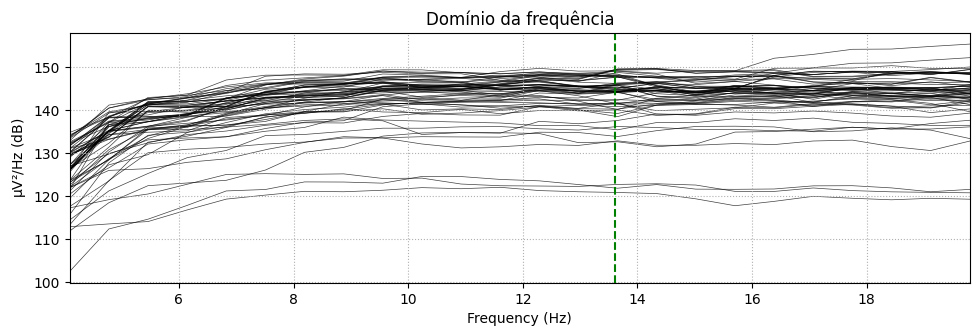

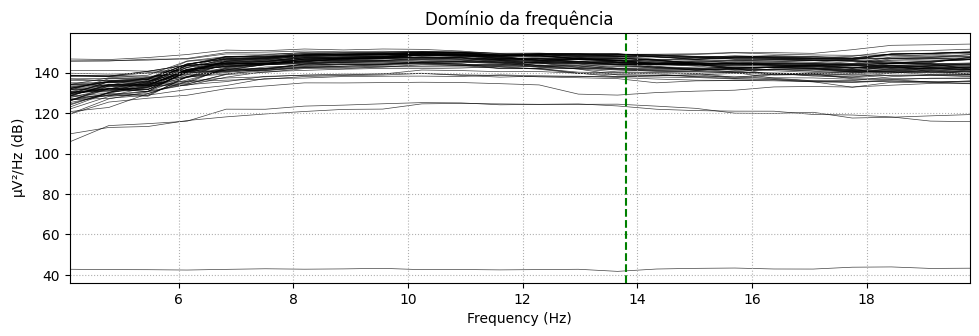

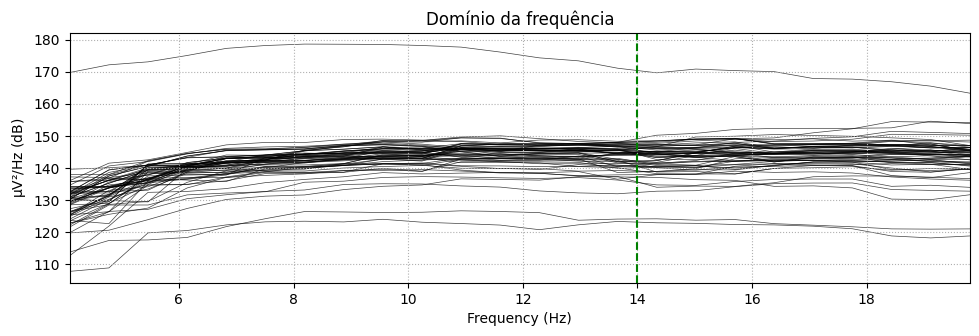

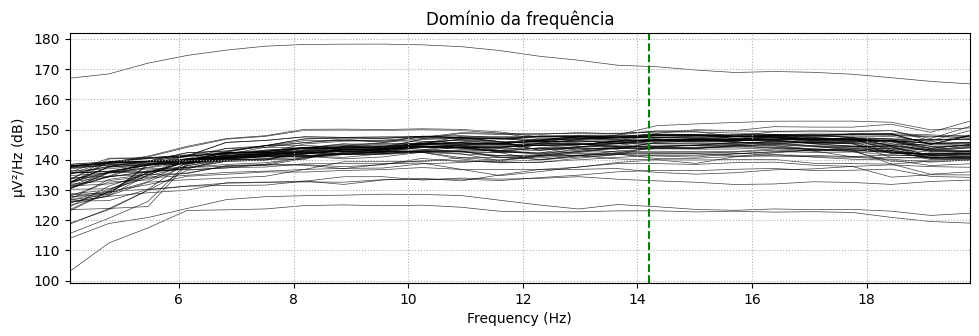

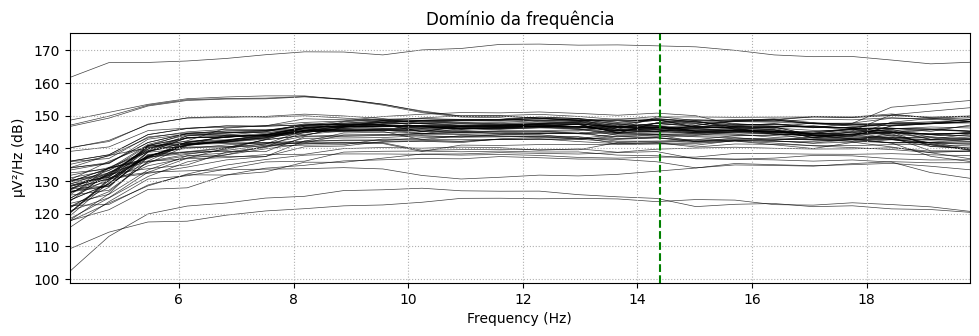

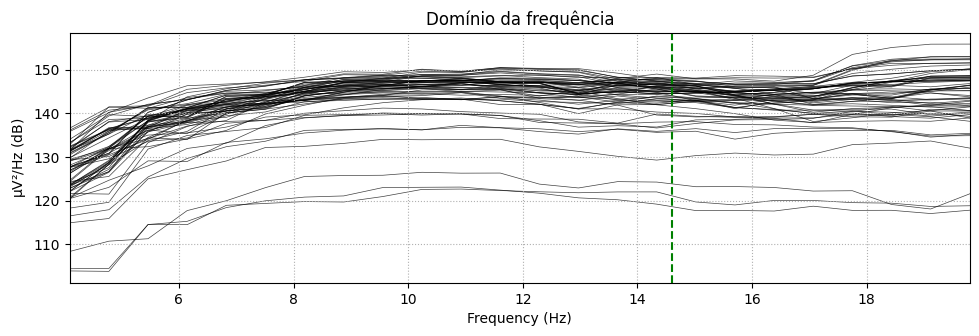

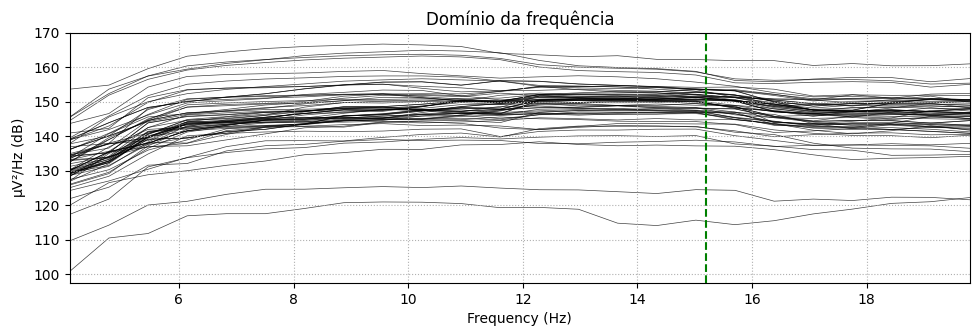

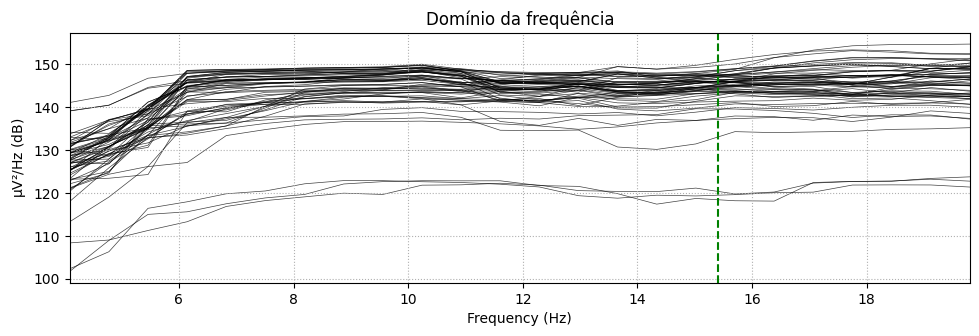

In [76]:

import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=0, fmax=40,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()
